<a href="https://colab.research.google.com/github/DevWidSiddxx/Revenue_Cycle_Optimisation/blob/main/MASTER_ml_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn matplotlib tensorflow


# Autoencoder for Anomaly Detection

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1793 - val_loss: 0.8906
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8297 - val_loss: 0.6691
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6230 - val_loss: 0.4904
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4592 - val_loss: 0.3834
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3522 - val_loss: 0.2964
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2689 - val_loss: 0.2099
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1842 - val_loss: 0.1395
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1211 - val_loss: 0.0896
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0777 - val_loss: 0.0583
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0492 - val_loss: 0.0394
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0329 - val_loss: 0.0282
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

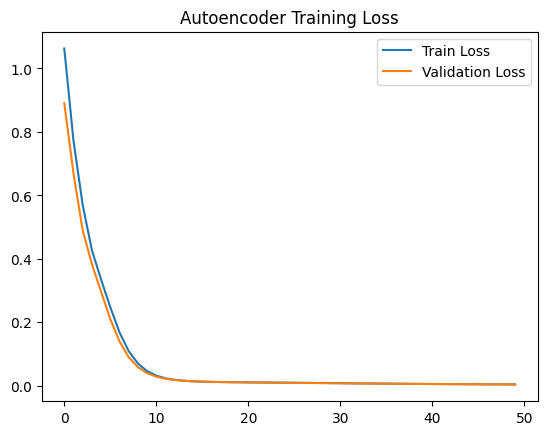

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Threshold: 1.3055642991369514e-05
Anomalies detected: 100 out of 2000


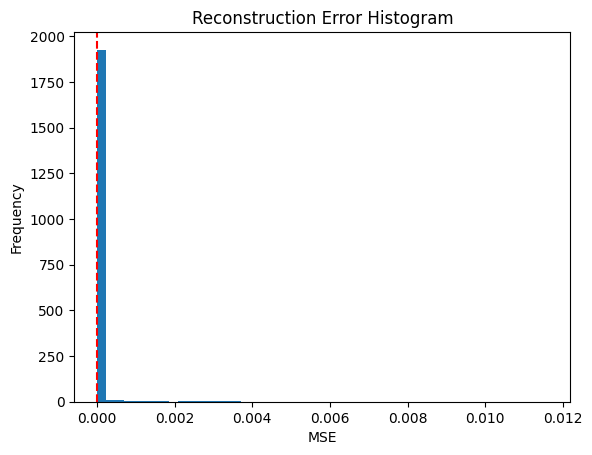

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load your transaction data
transactions = pd.read_csv("/content/transactions.csv")

# Feature engineering
transactions['UnpaidAmount'] = transactions['Amount'] - transactions['PaidAmount']
features = transactions[['Amount', 'PaidAmount', 'UnpaidAmount']]

# Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train/test split
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(2, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()

# Reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set anomaly threshold
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Print results
print(f"Threshold: {threshold}")
print(f"Anomalies detected: {np.sum(anomalies)} out of {len(mse)}")

# Optional: visualize reconstruction error
plt.hist(mse, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error Histogram")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()


🔍 Interpretation
🔵 Tall bar on the left near zero:
Most of your transactions are being reconstructed very well, meaning they're normal.

🔴 Red line (threshold):
Anything to the right of this line is considered an anomaly by the model.

⚠️ Anything beyond the threshold:
Those are your suspect transactions — potentially incorrect, fraudulent, or just rare patterns that differ from the norm.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


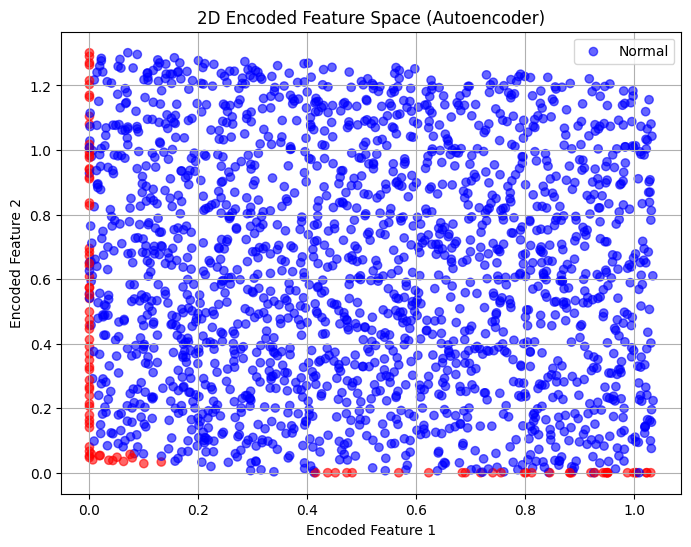

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Build encoder model to extract compressed 2D features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Get 2D encoded features for the test set
X_test_encoded = encoder.predict(X_test)

# Calculate reconstruction error again
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Determine anomalies
threshold = np.percentile(mse, 95)
is_anomaly = mse > threshold

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1],
            c=['red' if a else 'blue' for a in is_anomaly],
            alpha=0.6, label='Data Points')

plt.title('2D Encoded Feature Space (Autoencoder)')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.legend(['Normal', 'Anomaly'])
plt.grid(True)
plt.show()


# 🔵 Blue dots = Normal transactions.

# 🔴 Red dots = Anomalous transactions.

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8999 - val_loss: 0.6929
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6269 - val_loss: 0.4447
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3779 - val_loss: 0.2427
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2141 - val_loss: 0.1523
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1340 - val_loss: 0.1003
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0895 - val_loss: 0.0671
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0617 - val_loss: 0.0468
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0402 - val_loss: 0.0339
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0291 - val_loss: 0.0257
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0220 - val_loss: 0.0203
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0190 - val_loss: 0.0166
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model saved as autoencoder_model.h5
Model loaded from autoencoder_model.h5


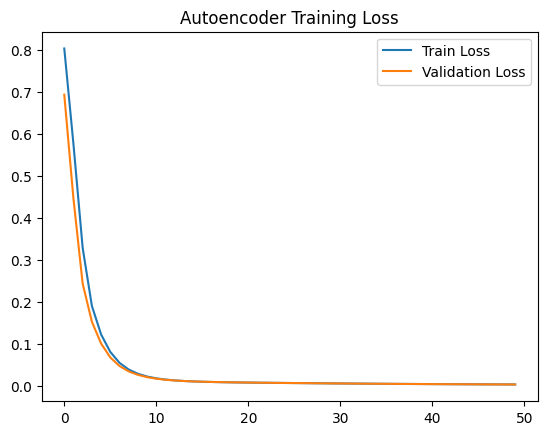

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Threshold: 9.902120866970921e-06
Anomalies detected: 100 out of 2000


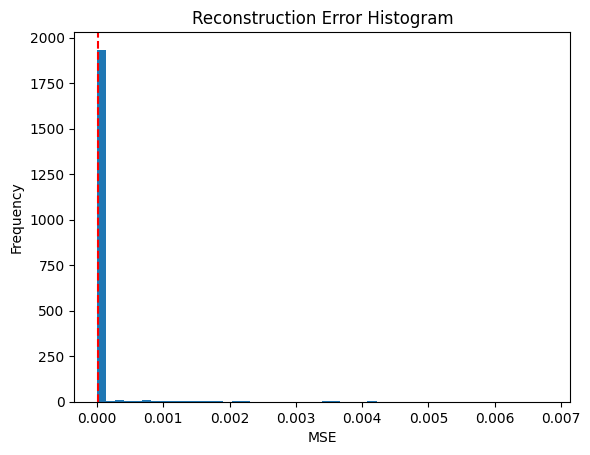

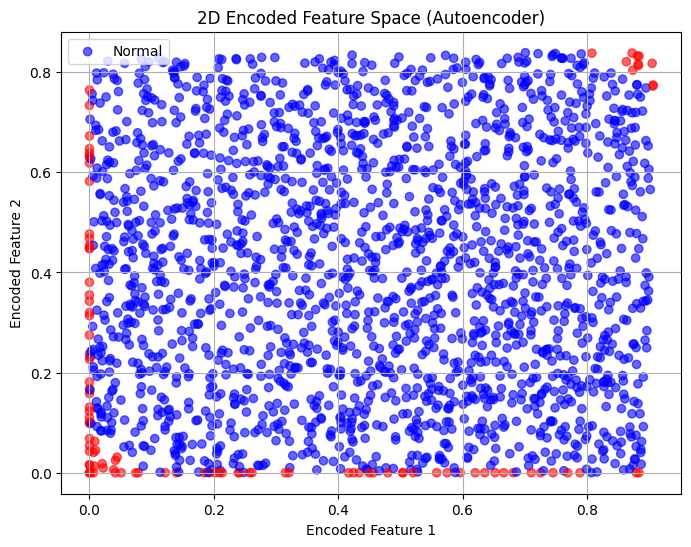

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load data
transactions = pd.read_csv("/content/transactions.csv")

# Feature engineering
transactions['UnpaidAmount'] = transactions['Amount'] - transactions['PaidAmount']
features = transactions[['Amount', 'PaidAmount', 'UnpaidAmount']]

# Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train/test split
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(2, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

from tensorflow.keras.losses import MeanSquaredError
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())


# Train model
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1)

# Save the trained model
autoencoder.save("autoencoder_model.h5")
print("Model saved as autoencoder_model.h5")

# Load the model
loaded_model = load_model("autoencoder_model.h5")
print("Model loaded from autoencoder_model.h5")

# Plot training loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()

# Build encoder model to extract compressed 2D features
encoder = Model(inputs=loaded_model.input, outputs=loaded_model.layers[1].output)

# Get 2D encoded features
X_test_encoded = encoder.predict(X_test)

# Predict and compute reconstruction error
X_test_pred = loaded_model.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Anomaly detection
threshold = np.percentile(mse, 95)
is_anomaly = mse > threshold

# Print summary
print(f"Threshold: {threshold}")
print(f"Anomalies detected: {np.sum(is_anomaly)} out of {len(mse)}")

# Plot reconstruction error
plt.figure()
plt.hist(mse, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error Histogram")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()

# Visualize encoded space
plt.figure(figsize=(8, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1],
            c=['red' if a else 'blue' for a in is_anomaly],
            alpha=0.6)
plt.title('2D Encoded Feature Space (Autoencoder)')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.grid(True)
plt.legend(['Normal', 'Anomaly'])
plt.show()
